# Retro Branching

In the last tutorial notebook, you saw how to track the B&B search tree with `Ecole` and `PySCIPOpt`. Now, we will see how to use this to construct retrospective trajectories which can then be used for retro branching.

In [41]:
import ecole

from retro_branching.utils import SearchTree, seed_stochastic_modules_globally
from retro_branching.environments import EcoleBranching
from retro_branching.agents import PseudocostBranchingAgent

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms.shortest_paths.generic import shortest_path
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

import math
from ordered_set import OrderedSet
import copy
from collections import defaultdict

The easiest way to integrate the retro branching approach into an `Ecole` context is to create a custom `Ecole` reward. 

At each step in the original episode, this reward will return `None`. After the final terminal step, the reward will return a list of dictionaries. Each dictionary represents one retrospective trajectory. For a given retrospective trajectory dictionary, each key-value dictionary is a transition-reward pair, where the keys are the step index of the original episode for a given transition, and the value is the corresponding retrospective trajectory reward being given.

In [42]:
class RetroBranching:
    def __init__(self, 
                 retro_trajectory_construction='max_leaf_lp_gain',
                 use_retro_trajectories=True,
                 only_use_leaves_closed_by_brancher_as_terminal_nodes=True,
                 debug_mode=False):
        '''
        Waits until end of episode to calculate rewards for each step, then retrospectively
        goes back through each step in the episode and calculates reward for that step.
        I.e. reward returned will be None until the end of the episode, at which
        point a dict mapping episode_step_idx for optimal path nodes to reward will be returned.
        
        Args:
            retro_trajectory_construction ('random', 'deepest', 'shortest', 'max_lp_gain', 'min_lp_gain', 'max_leaf_lp_gain', 
                'reverse_visitation_order', 'visitation_order'): Which policy to use when choosing a leaf node as the final 
                node to construct a retrospective trajectory.
            use_retro_trajectories (bool): If False, will return original dict mapping before forming retrospective episodes.
            only_use_leaves_closed_by_brancher_as_terminal_nodes (bool): If True, when constructing retrospective trajectories,
                will only consider leaves which were fathomed by the brancher as the last transition for a retrospective trajectory.
        '''
        self.retro_trajectory_construction = retro_trajectory_construction
        self.use_retro_trajectories = use_retro_trajectories
        self.only_use_leaves_closed_by_brancher_as_terminal_nodes = only_use_leaves_closed_by_brancher_as_terminal_nodes
        self.debug_mode = debug_mode

    def before_reset(self, model):
        self.started = False
        
    def get_path_node_scores(self, tree, path):
        # use original node score as score for each node
        return [tree.nodes[node]['score'] for node in path]

    def conv_path_to_step_idx_reward_map(self, path):        
        # register which nodes have been directly included in the sub-tree
        for node in path:
            self.nodes_added.add(node)
        
        # get rewards at each step in sub-tree episode
        path_node_rewards = self.get_path_node_scores(self.tree.tree, path)

        # get episode step indices at which each node in sub-tree was visited
        path_to_step_idx = {node: self.visited_nodes_to_step_idx[node] for node in path}

        # map each path node episode step idx to its corresponding reward
        step_idx_to_reward = {step_idx: r for step_idx, r in zip(list(path_to_step_idx.values()), path_node_rewards)}
        
        return step_idx_to_reward

    def _select_path_in_subtree(self, subtree):
        for root_node in subtree.nodes:
            if subtree.in_degree(root_node) == 0:
                # node is root
                break

        # use a construction method to select a sub-tree episode path through the sub-tree
        if self.retro_trajectory_construction == 'max_lp_gain' or self.retro_trajectory_construction == 'min_lp_gain':
            # iteratively decide next node in path at each step
            curr_node, path = root_node, [root_node]
            while True:
                # get potential next node(s)
                children = [child for child in subtree.successors(curr_node)]
                if len(children) == 0:
                    # curr node is final leaf node, path complete
                    break
                else:
                    # select next node
                    if self.retro_trajectory_construction == 'max_lp_gain':
                        idx = np.argmax([subtree.nodes[child]['lower_bound'] for child in children])
                    elif self.retro_trajectory_construction == 'min_lp_gain':
                        idx = np.argmin([subtree.nodes[child]['lower_bound'] for child in children])
                    else:
                        raise Exception(f'Unrecognised retro_trajectory_construction {self.retro_trajectory_construction}')
                    curr_node = children[idx]
                    path.append(curr_node)
                
        else:
            # first get leaf nodes and then use construction method to select leaf target for shortest path
            if self.only_use_leaves_closed_by_brancher_as_terminal_nodes:
                leaf_nodes = [node for node in subtree.nodes() if (subtree.out_degree(node) == 0 and node in self.tree.tree.graph['fathomed_node_ids'])]
            else:
                leaf_nodes = [node for node in subtree.nodes() if subtree.out_degree(node) == 0]
            
            if len(leaf_nodes) == 0:
                # could not find any valid path through sub-tree
                return []

            if self.retro_trajectory_construction == 'random':
                # randomly choose leaf node as final node
                final_node = leaf_nodes[random.choice(range(len(leaf_nodes)))]
            elif self.retro_trajectory_construction == 'deepest':
                # choose leaf node which would lead to deepest subtree as final node
                depths = [len(shortest_path(subtree, source=root_node, target=leaf_node)) for leaf_node in leaf_nodes]
                final_node = leaf_nodes[depths.index(max(depths))]
            elif self.retro_trajectory_construction == 'shortest':
                # choose leaf node which would lead to shortest subtree as final node
                depths = [len(shortest_path(subtree, source=root_node, target=leaf_node)) for leaf_node in leaf_nodes]
                final_node = leaf_nodes[depths.index(min(depths))]
            elif self.retro_trajectory_construction == 'max_leaf_lp_gain':
                # choose leaf node which has greatest LP gain as final node
                lp_gains = [subtree.nodes[leaf_node]['lower_bound'] for leaf_node in leaf_nodes]
                final_node = leaf_nodes[lp_gains.index(max(lp_gains))]
            elif self.retro_trajectory_construction == 'reverse_visitation_order':
                step_node_visited = [self.tree.tree.nodes[leaf_node]['step_visited'] for leaf_node in leaf_nodes]
                final_node = leaf_nodes[step_node_visited.index(max(step_node_visited))]
            elif self.retro_trajectory_construction == 'visitation_order':
                step_node_visited = [self.tree.tree.nodes[leaf_node]['step_visited'] for leaf_node in leaf_nodes]
                final_node = leaf_nodes[step_node_visited.index(min(step_node_visited))]
            else:
                raise Exception(f'Unrecognised retro_trajectory_construction {self.retro_trajectory_construction}')
            path = shortest_path(self.tree.tree, source=root_node, target=final_node)

        return path

    def extract(self, model, done):
        if not self.started:
            self.started = True
            self.tree = SearchTree(model)
            return None

        if not done:
            # update B&B tree
            self.tree.update_tree(model)
            return None
        
        else:
            # instance finished, retrospectively create subtree episode paths
            self.tree.update_tree(model)

            if self.tree.tree.graph['root_node'] is None:
                # instance was pre-solved
                return [{0: 0}]

            # collect sub-tree episodes
            subtrees_step_idx_to_reward = []

            # keep track of which nodes have been added to a sub-tree
            self.nodes_added = set()
            
            if self.debug_mode:
                print('\nB&B tree:')
                print(f'All nodes saved: {self.tree.tree.nodes()}')
                print(f'Visited nodes: {self.tree.tree.graph["visited_node_ids"]}')
                self.tree.render()

            # remove nodes which were never visited by the brancher and therefore do not have a score or next state
            nodes = [node for node in self.tree.tree.nodes]
            for node in nodes:
                if 'step_visited' not in self.tree.tree.nodes[node]:
                    self.tree.tree.remove_node(node)
                    if self.debug_mode:
                        print(f'Removing node {node} since was never visited by brancher.')
                    if node in self.tree.tree.graph['visited_node_ids']:
                        # hack: SCIP sometimes returns large int rather than None node_id when episode finished
                        # since never visited this node (since no score assigned), do not count this node as having been visited when calculating paths below
                        if self.debug_mode:
                            print(f'Removing node {node} from visied IDs since was never actually visited by brancher.')
                        self.tree.tree.graph['visited_node_ids'].remove(node)                    
                        
            # set node scores (transition rewards)
            for node in self.tree.tree.nodes:
                if node in self.tree.tree.graph['fathomed_node_ids']:
                    self.tree.tree.nodes[node]['score'] = 0
                else:
                    self.tree.tree.nodes[node]['score'] = -1

            # map which nodes were visited at which step in episode
            self.visited_nodes_to_step_idx = {node: idx for idx, node in enumerate(self.tree.tree.graph['visited_node_ids'])}

            if not self.use_retro_trajectories:
                # do not use any sub-tree episodes, just return whole B&B tree episode
                step_idx_to_reward = {}
                for node, step_idx in self.visited_nodes_to_step_idx.items():
                    step_idx_to_reward[step_idx] = self.tree.tree.nodes[node]['score']
                subtrees_step_idx_to_reward.append(step_idx_to_reward)
                return subtrees_step_idx_to_reward 
            
            root_node = list(self.tree.tree.graph['root_node'].keys())[0]

            # create sub-tree episodes from remaining B&B nodes visited by agent
            while True:
                # create depth first search sub-trees from nodes still leftover
                nx_subtrees = []
                
                # construct sub-trees containing prospective sub-tree episode(s) from remaining nodes
                if len(self.nodes_added) > 0:
                    for node in self.nodes_added:
                        children = [child for child in self.tree.tree.successors(node)]
                        for child in children:
                            if child not in self.nodes_added:
                                nx_subtrees.append(dfs_tree(self.tree.tree, child))
                else:
                    # not yet added any nodes to a sub-tree, whole B&B tree is first 'sub-tree'
                    nx_subtrees.append(dfs_tree(self.tree.tree, root_node))
                            
                for i, subtree in enumerate(nx_subtrees):
                    # init node attributes for nodes in subtree (since these are not transferred into new subtree by networkx)
                    for node in subtree.nodes:
                        subtree.nodes[node]['score'] = self.tree.tree.nodes[node]['score']
                        subtree.nodes[node]['lower_bound'] = self.tree.tree.nodes[node]['lower_bound']

                    # choose episode path through sub-tree
                    path = self._select_path_in_subtree(subtree)
                    
                    if len(path) > 0:
                        # gather rewards in sub-tree
                        subtree_step_idx_to_reward = self.conv_path_to_step_idx_reward_map(path)
                        if subtree_step_idx_to_reward is not None:
                            subtrees_step_idx_to_reward.append(subtree_step_idx_to_reward)
                        else:
                            # subtree was not deep enough to be added
                            pass
                    else:
                        # cannot establish valid path through sub-tree, do not consider nodes in this sub-tree again
                        for node in subtree.nodes():
                            self.nodes_added.add(node)

                if len(nx_subtrees) == 0:
                    # all sub-trees added
                    break
                    
            if self.debug_mode:
                print(f'visited_nodes_to_step_idx: {self.visited_nodes_to_step_idx}')
                step_idx_to_visited_nodes = {val: key for key, val in self.visited_nodes_to_step_idx.items()}
                print(f'step_idx_to_visited_nodes: {step_idx_to_visited_nodes}')
                for i, ep in enumerate(subtrees_step_idx_to_reward):
                    print(f'>>> sub-tree episode {i+1}: {ep}')
                    ep_path = [step_idx_to_visited_nodes[idx] for idx in ep.keys()]
                    print(f'path: {ep_path}')
                    ep_dual_bounds = [self.tree.tree.nodes[node]['lower_bound'] for node in ep_path]
                    print(f'ep_dual_bounds: {ep_dual_bounds}')
            
            if len(subtrees_step_idx_to_reward) == 0:
                # solved at root so path length < min path length so was never added to subtrees
                return [{0: 0}]
            else:
                return subtrees_step_idx_to_reward

In [49]:
seed = 2 # 1
seed_stochastic_modules_globally(default_seed=seed)

agent = PseudocostBranchingAgent()

env = EcoleBranching(observation_function='default',
                     information_function='default',
                     reward_function='default',
                     scip_params='gasse_2019' # default dfs gasse_2019
                    )
env.seed(seed)

ecole.seed(seed)
instances = ecole.instance.SetCoverGenerator(n_rows=200, n_cols=200, density=0.05) # 200x200seed=1 300x300seed=2

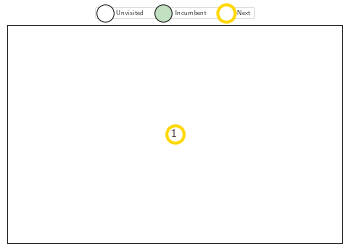

Step 0 | Nodes added: 1 | primal bound: 750.0 | dual bound: 719.8613400624153 | prev_node_id (branched at): 1 | next_node_id (not yet branched at): 3 | optimum_node_id: 1
Custom reward: None



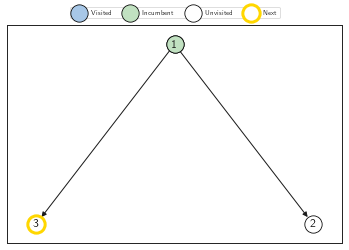

Step 1 | Nodes added: 1 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 3 | next_node_id (not yet branched at): 2 | optimum_node_id: 1
Custom reward: None



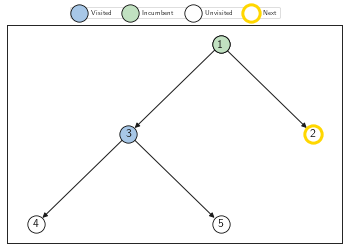

Step 2 | Nodes added: 1 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 2 | next_node_id (not yet branched at): 4 | optimum_node_id: 1
Custom reward: None



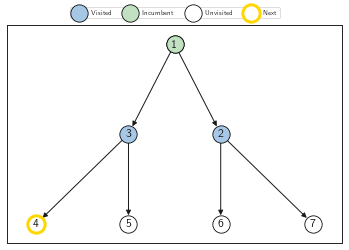

Step 3 | Nodes added: 1 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 4 | next_node_id (not yet branched at): 5 | optimum_node_id: 1
Custom reward: None



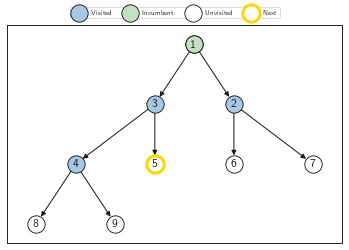

Step 4 | Nodes added: 1 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 5 | next_node_id (not yet branched at): 10 | optimum_node_id: 1
Custom reward: None



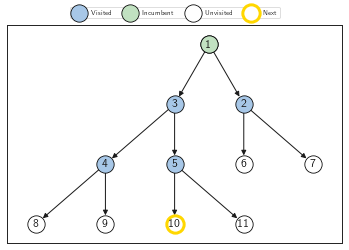

Step 5 | Nodes added: 2 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 10 | next_node_id (not yet branched at): 13 | optimum_node_id: 1
Custom reward: None



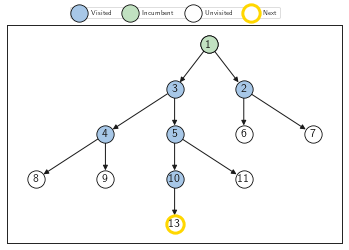

Step 6 | Nodes added: 3 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 13 | next_node_id (not yet branched at): 7 | optimum_node_id: 1
Custom reward: None



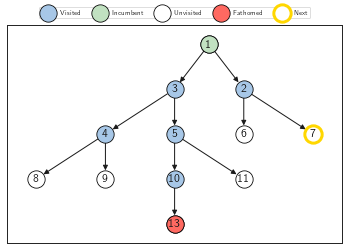

Step 7 | Nodes added: 3 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 7 | next_node_id (not yet branched at): 16 | optimum_node_id: 1
Custom reward: None



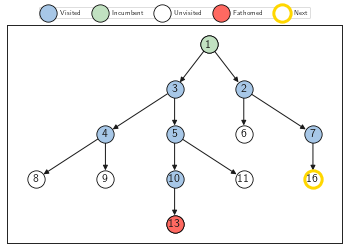

Step 8 | Nodes added: 1 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 16 | next_node_id (not yet branched at): 8 | optimum_node_id: 1
Custom reward: None



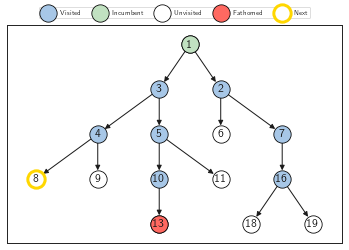

Step 9 | Nodes added: 1 | primal bound: 750.0 | dual bound: 727.9580540368407 | prev_node_id (branched at): 8 | next_node_id (not yet branched at): 20 | optimum_node_id: 1
Custom reward: None



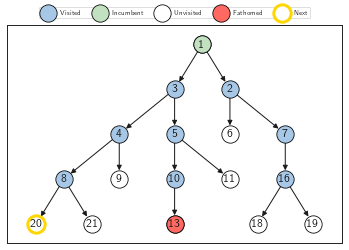

Step 10 | Nodes added: 5 | primal bound: 750.0 | dual bound: 736.0357142857143 | prev_node_id (branched at): 20 | next_node_id (not yet branched at): 6 | optimum_node_id: 1
Custom reward: None



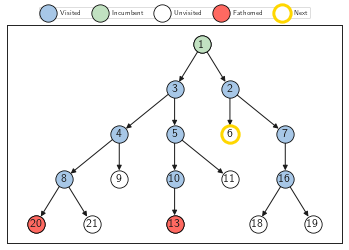

Step 11 | Nodes added: 1 | primal bound: 750.0 | dual bound: 736.0357142857143 | prev_node_id (branched at): 6 | next_node_id (not yet branched at): 25 | optimum_node_id: 1
Custom reward: None



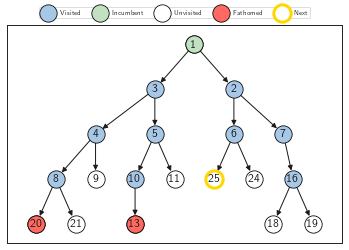

Step 12 | Nodes added: 1 | primal bound: 750.0 | dual bound: 736.0357142857143 | prev_node_id (branched at): 25 | next_node_id (not yet branched at): 26 | optimum_node_id: 1
Custom reward: None



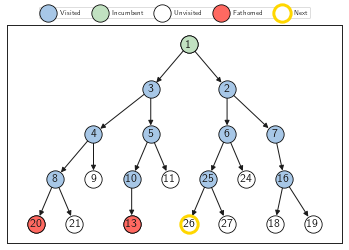


B&B tree:
All nodes saved: [1, 3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 18, 19, 20, 21, 25, 24, 26, 27]
Visited nodes: OrderedSet([1, 3, 2, 4, 5, 10, 13, 7, 16, 8, 20, 6, 25, 26])


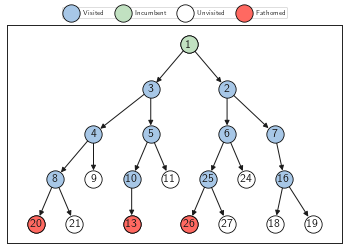

Removing node 9 since was never visited by brancher.
Removing node 11 since was never visited by brancher.
Removing node 18 since was never visited by brancher.
Removing node 19 since was never visited by brancher.
Removing node 21 since was never visited by brancher.
Removing node 24 since was never visited by brancher.
Removing node 27 since was never visited by brancher.
visited_nodes_to_step_idx: {1: 0, 3: 1, 2: 2, 4: 3, 5: 4, 10: 5, 13: 6, 7: 7, 16: 8, 8: 9, 20: 10, 6: 11, 25: 12, 26: 13}
step_idx_to_visited_nodes: {0: 1, 1: 3, 2: 2, 3: 4, 4: 5, 5: 10, 6: 13, 7: 7, 8: 16, 9: 8, 10: 20, 11: 6, 12: 25, 13: 26}
>>> sub-tree episode 1: {0: -1, 2: -1, 11: -1, 12: -1, 13: 0}
path: [1, 2, 6, 25, 26]
ep_dual_bounds: [719.8613400624153, 719.8613400624153, 727.9580540368407, 743.75, 746.1648351648352]
>>> sub-tree episode 2: {1: -1, 3: -1, 9: -1, 10: 0}
path: [3, 4, 8, 20]
ep_dual_bounds: [733.3, 733.3, 740.5473321858864, 745.7755102040817]
>>> sub-tree episode 3: {4: -1, 5: -1, 6: 0}
path:

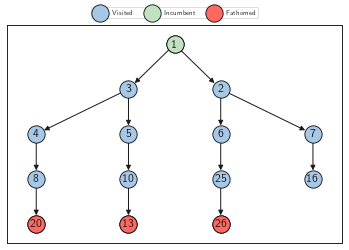


Finished | primal bound: 750.0 | dual bound: 750.0 | # nodes: 29 | Final node: {26: <pyscipopt.scip.Node object at 0x7ffaa9a4ec30>} | Optimum node id: 1
SCIP NTotalNodes: 29
Custom reward: [{0: -1, 2: -1, 11: -1, 12: -1, 13: 0}, {1: -1, 3: -1, 9: -1, 10: 0}, {4: -1, 5: -1, 6: 0}]


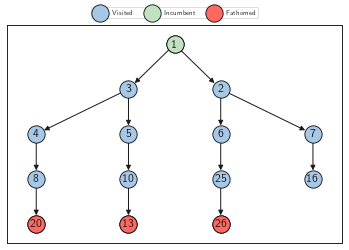

In [50]:
# initialise custom reward object
custom_reward = RetroBranching(debug_mode=True)

# initialise an instance which is not pre-solved by SCIP
done = True
while done:
    env.seed(seed)
    instance = next(instances)
    custom_reward.before_reset(instance)
    agent.before_reset(instance)
    obs, action_set, reward, done, info = env.reset(instance)
    _custom_reward = custom_reward.extract(env.model, done)
    
# solve the instance with the brancher
t = 0
tree = custom_reward.tree
tree.render()
prev_obs = copy.deepcopy(obs)
original_transitions = []
while not done:
    # select branching action
    action, action_idx = agent.action_select(action_set, model=env.model, done=done)
    obs, action_set, reward, done, info = env.step(action)
    _custom_reward = custom_reward.extract(env.model, done)
    
    if done:
        obs = copy.deepcopy(prev_obs)
    
    # store transition
    original_transitions.append({'obs': prev_obs,
                               'action': action,
                               'reward': None,
                               'done': done,
                               'next_obs': obs})
    
    # update prev obs
    prev_obs = copy.deepcopy(obs)
    
    # print step info
    m = env.model.as_pyscipopt()
    if len(tree.tree.graph['visited_node_ids']) > 1 and not done:
        prev_node_id = tree.tree.graph['visited_node_ids'][-2]
    else:
        prev_node_id = tree.tree.graph['visited_node_ids'][-1]
    curr_node_id = tree.curr_node_id
    print(f'Step {t} | Nodes added: {abs(int(reward["num_nodes"]))} | primal bound: {m.getPrimalbound()} | dual bound: {m.getDualbound()} | prev_node_id (branched at): {prev_node_id} | next_node_id (not yet branched at): {curr_node_id} | optimum_node_id: {tree.tree.graph["optimum_node_ids"][-1]}')
    print(f'Custom reward: {_custom_reward}\n')
    
    # update search tree
    tree.render()
        
    t += 1
        
m = env.model.as_pyscipopt()
print(f'\nFinished | primal bound: {m.getPrimalbound()} | dual bound: {m.getDualbound()} | # nodes: {m.getNTotalNodes()} | Final node: {tree.tree.graph["visited_nodes"][-1]} | Optimum node id: {tree.tree.graph["optimum_node_ids"][-1]}')
print(f'SCIP NTotalNodes: {env.model.as_pyscipopt().getNTotalNodes()}')
print(f'Custom reward: {_custom_reward}')
tree.render()

Now we can use our retrospectively defined trajectories to index the original transitions and update them before adding the retrospectively defined transitions to the replay buffer whose experiences will be used for learning:

In [51]:
replay_buffer = []
for retro_traj in _custom_reward:
    for step_idx, reward in retro_traj.items():
        transition = original_transitions[step_idx]
        transition['reward'] = reward
        replay_buffer.append(transition)
display(replay_buffer)

[{'obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa91bdfb0>,
  'action': 177,
  'reward': -1,
  'done': False,
  'next_obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa90daef0>},
 {'obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa992e630>,
  'action': 108,
  'reward': -1,
  'done': False,
  'next_obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa991f4f0>},
 {'obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa92fa970>,
  'action': 47,
  'reward': -1,
  'done': False,
  'next_obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa9528d70>},
 {'obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa8d131b0>,
  'action': 118,
  'reward': -1,
  'done': False,
  'next_obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa9513970>},
 {'obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa8f43fb0>,
  'action': 65,
  'reward': 0,
  'done': True,
  'next_obs': <ecole.core.observation.NodeBipartiteObs at 0x7ffaa96333b0>},
 {'obs': <ecole.core.obs